In [88]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization, Concatenate

In [89]:
data_path = "/kaggle/input/flowers-recognition/flowers"
images = []
labels = []

for subfolder in os.listdir(data_path):
    subfolder_path = os.path.join(data_path, subfolder)
    if not os.path.isdir(subfolder_path):
        continue
    
    for image_filename in os.listdir(subfolder_path):
        image_path = os.path.join(subfolder_path, image_filename)
        images.append(image_path)
        labels.append(subfolder)

data = pd.DataFrame({'image': images, 'label': labels})

In [90]:
X = np.array(images)
y = np.array(labels)

In [91]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [92]:
y_onehot = to_categorical(y_encoded, num_classes=5)


In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42)

In [94]:
def load_images(image_paths, img_size=(100, 100)):
    images = []
    for img_path in image_paths:
        img = load_img(img_path, target_size=img_size)
        img_array = img_to_array(img)
        images.append(img_array)
    return np.array(images)

X_train = load_images(X_train, img_size=(100, 100))
X_test = load_images(X_test, img_size=(100, 100))

In [95]:
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (3453, 100, 100, 3)
X_test shape: (864, 100, 100, 3)
y_train shape: (3453, 5)
y_test shape: (864, 5)


# Y-Net

# CNN Model 1

In [96]:
input_shape = (100, 100, 3)

input1 = Input(shape=input_shape)
x1 = Conv2D(32, (3,3), activation='relu')(input1)
x1 = BatchNormalization()(x1)
x1 = MaxPooling2D(2)(x1)

x1 = Conv2D(64, (3,3), activation='relu')(x1)
x1 = BatchNormalization()(x1)
x1 = MaxPooling2D(2)(x1)

x1 = Conv2D(128, (3,3), activation='relu')(x1)
x1 = BatchNormalization()(x1)
x1 = MaxPooling2D(2)(x1)

x1 = Conv2D(256, (3,3), activation='relu')(x1)
x1 = BatchNormalization()(x1)
x1 = MaxPooling2D(2)(x1)
x1 = Dropout(0.25)(x1)

model1 = Model(inputs=input1, outputs=x1)

# CNN Model 2

In [97]:
input2 = Input(shape=input_shape)
x2 = Conv2D(32, (3,3), activation='relu')(input2)
x2 = BatchNormalization()(x2)
x2 = MaxPooling2D(2)(x2)

x2 = Conv2D(64, (3,3), activation='relu')(x2)
x2 = BatchNormalization()(x2)
x2 = MaxPooling2D(2)(x2)

x2 = Conv2D(128, (3,3), activation='relu')(x2)
x2 = BatchNormalization()(x2)
x2 = MaxPooling2D(2)(x2)

x2 = Conv2D(256, (3,3), activation='relu')(x2)
x2 = BatchNormalization()(x2)
x2 = MaxPooling2D(2)(x2)
x2 = Dropout(0.25)(x2)

model2 = Model(inputs=input2, outputs=x2)

# Concatenate Model 1 and Model 2

In [98]:
merged_output = Concatenate()([model1.output, model2.output])

flattened_output = Flatten()(merged_output)

x = Dense(128, activation="relu")(flattened_output)
x = Dropout(0.5)(x)
final_output = Dense(5, activation="softmax")(x)

In [99]:
combined_model = Model(inputs=[model1.input, model2.input], outputs=final_output)


In [100]:
combined_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
combined_model.summary()

Model: "functional_53"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11            │ (None, 100, 100, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_12            │ (None, 100, 100, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_44 (Conv2D)        │ (None, 98, 98, 32)     │            896 │ input_layer_11[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_48 (Conv2D)        │ (None, 98, 98, 32)     │            896 │ input_layer_12[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_44    │ (None, 98, 98, 32)     │            128 │ conv2d_44[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_48    │ (None, 98, 98, 32)     │            128 │ conv2d_48[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_44          │ (None, 49, 49, 32)     │              0 │ batch_normalization_4… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_48          │ (None, 49, 49, 32)     │              0 │ batch_normalization_4… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_45 (Conv2D)        │ (None, 47, 47, 64)     │         18,496 │ max_pooling2d_44[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_49 (Conv2D)        │ (None, 47, 47, 64)     │         18,496 │ max_pooling2d_48[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_45    │ (None, 47, 47, 64)     │            256 │ conv2d_45[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_49    │ (None, 47, 47, 64)     │            256 │ conv2d_49[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_45          │ (None, 23, 23, 64)     │              0 │ batch_normalization_4… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_49          │ (None, 23, 23, 64)     │              0 │ batch_normalization_4… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_46 (Conv2D)   

 Total params: 1,830,021 (6.98 MB)

 Trainable params: 1,828,101 (6.97 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [101]:
history = combined_model.fit(
    [X_train, X_train],  
    y_train,
    epochs=20,
    batch_size=32,
    validation_data=([X_test, X_test], y_test)
)

Epoch 1/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 18s 76ms/step - accuracy: 0.3667 - loss: 2.9171 - val_accuracy: 0.4410 - val_loss: 1.2791
Epoch 2/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.4930 - loss: 1.2465 - val_accuracy: 0.5544 - val_loss: 1.1192
Epoch 3/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.5417 - loss: 1.1450 - val_accuracy: 0.5741 - val_loss: 1.0588
Epoch 4/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.5632 - loss: 1.0790 - val_accuracy: 0.5185 - val_loss: 1.6938
Epoch 5/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6036 - loss: 1.0082 - val_accuracy: 0.5683 - val_loss: 1.0550
Epoch 6/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6320 - loss: 0.9672 - val_accuracy: 0.6400 - val_loss: 0.9419
Epoch 7/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6396 - loss: 0.9187 - val_accuracy: 0.6308 - val_loss: 0.9266
Epoch 8/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.6719 - loss: 0.8655 - val_acc

# Accuracy and Loss Plot

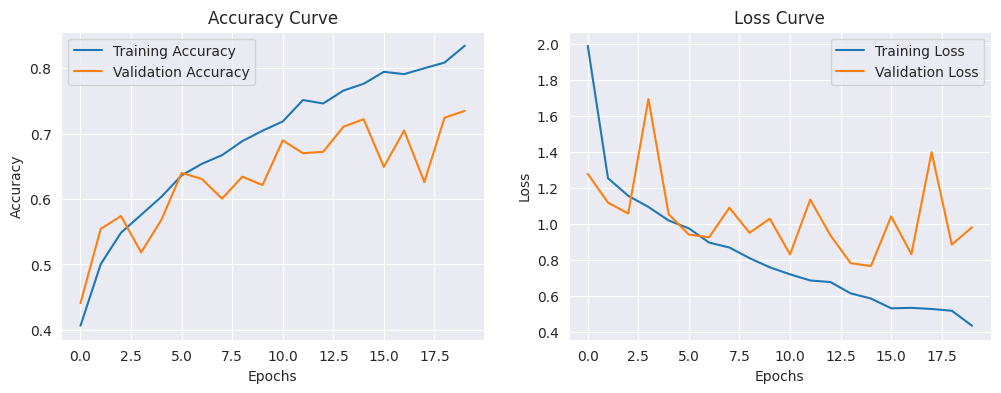

In [102]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


# Accuracy Score

In [103]:
test_loss, test_accuracy = combined_model.evaluate([X_test, X_test], y_test)
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Loss: {test_loss}")


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7484 - loss: 1.0253
Test Accuracy: 0.7349537014961243
Test Loss: 0.9827172160148621


# Confusion Matrix

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


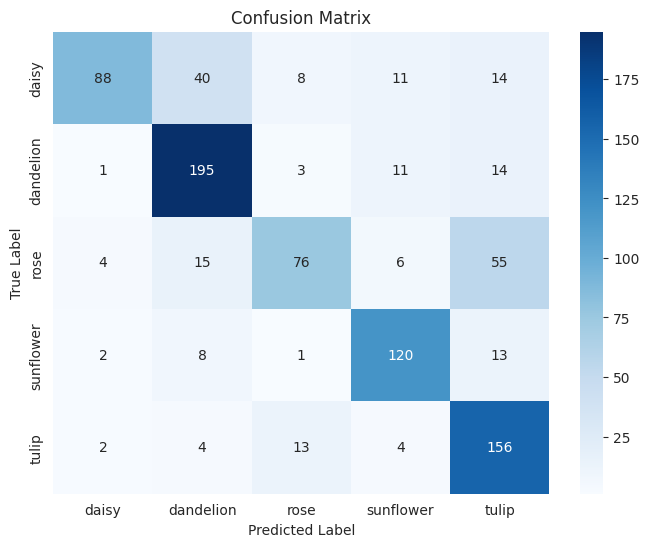

In [104]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = combined_model.predict([X_test, X_test])
y_pred_labels = np.argmax(y_pred, axis=1)

y_true_labels = np.argmax(y_test, axis=1)
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# Predicting Flower Class

In [105]:
from tensorflow.keras.preprocessing import image

def predict_image(img_path):
    img = load_img(img_path, target_size=(100, 100))  
    img_array = img_to_array(img)  
    img_array = np.expand_dims(img_array, axis=0)  
    img_array = img_array / 255.0  

    prediction = combined_model.predict([img_array, img_array])
    predicted_class = np.argmax(prediction, axis=1)
    
    return label_encoder.classes_[predicted_class][0]


In [117]:

img_path1 = '/kaggle/input/flowers-recognition/flowers/rose/12406229175_82e2ac649c_n.jpg'  
img_path2 = '/kaggle/input/flowers-recognition/flowers/rose/12406229175_82e2ac649c_n.jpg'  

print("Predicted class for Image 1:", predict_image(img_path1))
print("Predicted class for Image 2:", predict_image(img_path2))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted class for Image 1: dandelion
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted class for Image 2: dandelion


**Using Y-Net increases the number of parameters. In this model, the total number of parameters is 1,830,021. If a single-input, single-output CNN model were used instead, the number of parameters would be lower. Y-Net is beneficial for multimodal data processing. In this case, Y-Net was used only for testing purposes on this dataset.**